# Desafio 

#### Problema de Negócio
Você trabalha em uma empresa do tipo e-commerce que vende produtos para cabelo personalizados. Para personalizar o produto, a empresa solicita que o cliente preencha um formulário onde irá contar sobre a sua rotina e seu cabelo. Após finalizar o preenchimento, o cliente é direcionado automaticamente para o checkout, onde ele irá optar por fechar a compra ou não.
A experiência de venda online é baseada em três etapas:

- Preenchimento do formulário
- Seleção dos produtos
- Fechamento da compra

#### Problema e desafio
A empresa está gastando muito dinheiro com disparos via Whatsapp para pessoas que preenchem o formulário (leads), desta forma seria interessante qualificar quem são os leads que possuem maior probabilidade de efetuar uma compra e assim tornar os disparos mais efetivos.

Você então é convocado para solucionar tal desafio, e portanto deve achar a correlação entre compradores e leads.
Para isso, acesse o banco de dados presente em sua empresa para fazer a coleta dos dados, e use os recursos ao seu alcance para solucionar o problema e apresentar as suas conclusões.

### 1) Leitura dos pacotes

In [76]:
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix         # matriz de confusão
from sklearn.metrics import accuracy_score           # acurácia do modelo
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler       # escala
from sklearn.ensemble import ExtraTreesClassifier
import math
import warnings
warnings.filterwarnings("ignore")

### 2) Leitura dos dados

In [77]:
# Connectando com o database
connection = psycopg2.connect(user="zgbodaynfjorzt",
                                  password="d2b11c0c6039df67f39d22f680fb92a843a1b652e3d5b692f6670c0a2abc2804",
                                  host="ec2-3-222-74-92.compute-1.amazonaws.com",
                                  port="5432",
                                  database="dfo2vqe9hs2knm")

In [78]:
# lendo as tabelas (forms)
forms = pd.read_sql("select * from \"forms\"", connection);

In [79]:
# vendo como está a tabela
forms.head(5)

,id_form,id_cliente,data,sistema_operacional,navegador,localizacao,locale,cidade,estado,qtde_lavagem_semana,...,tipo_fios,procedimentos,tempo_procedimento,dieta,atividade_fisica,frequencia_estresse,caracteristica,faixa_etaria,efeitos_desejados,fragancia
0,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,4,...,Pontas duplas,Nenhum,Há 2 semanas,Celíaca,Frequente,Nunca,Característica 1,25 a 34,Efeito 7,Rosas
1,72830da153824af486be15cd48b3f3,9a48802d8290d19471f3,2022-01-04 08:39:53,Windows,Chrome,"Ribeirão Preto, Sao Paulo",BR,RIBEIRÃO PRETO,SAO PAULO,7,...,Perfeitos,Todos acima,Há mais de 1 mês,Nenhuma restrição,Nunca,Nunca,Característica 6,55 a 64,Efeito 1,Eucalipto
2,d101fc0075dac29db1168cfc61ad44,c3344fad450ee424700d,2022-01-04 19:34:05,Android,Chrome,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,2,...,Rebeldes,Todos acima,Há mais de 1 mês,Nenhuma restrição,Raramente,Regularmente,Característica 7,2 a 10,Efeito 7,Rosas
3,0957fb9d7be36b4d079b6582bb6785,8105e34124e90300d8b5,2022-01-05 18:29:41,Android,Chrome,"Manchester, England",BR,MANCHESTER,ENGLAND,5,...,Rebeldes,Todos acima,Há mais de 1 mês,Celíaca,Raramente,Regularmente,Característica 7,25 a 34,Efeito 7,Rosas
4,ba73bdcc6c063ab08b533eae5505eb,636382f3f545eec3fe97,2022-01-07 11:44:31,Android,Chrome,"Tijucas, Santa Catarina",BR,TIJUCAS,SANTA CATARINA,4,...,Rebeldes,Tintura,Há 1 semana,Celíaca,Sempre,Nunca,Característica 10,18 a 24,Efeito 7,Eucalipto


In [80]:
# vendo a dimensão
forms.shape

(427950, 23)

In [81]:
# lendo as tabelas (orders)
orders = pd.read_sql("select * from \"orders\"", connection);

In [82]:
# vendo como está a tabela
orders.head(5)

,id_pedido,id_cliente,data_pedido,status_pagamento,tipo_pagamento,valor_total,valor_desconto,frete_gratis,cidade,estado,locale,utm_source,target
0,bcd62f817162847,05dc2629809bac1c7185,2022-06-10 16:44:48,Entregue,CARTÃO,133.23,137.35,True,Estiva Gerbi,SP,BR,None,1
1,a7a7df267e6b5aa,a9394ee62a542adf27c0,2022-06-10 16:07:31,Cancelado,CARTÃO,176.18,109.88,False,Rio Verde,GO,BR,linktree,1
2,180fd3a5a094e20,5a13ec09afbc65ffc9ff,2022-06-10 16:53:50,Entregue,CARTÃO,133.23,137.35,True,Tupã,SP,BR,influencer,1
3,bda95f0b11e0481,835e3a24859952bee62f,2022-06-10 16:13:34,Entregue,CARTÃO,87.25,59.96,True,São Paulo,SP,BR,None,1
4,ed692fbba172e62,764720564bb8612e5389,2022-06-10 16:16:02,Cancelado,PIX,137.35,137.35,True,Marabá,PA,BR,influencer,1


In [83]:
# vendo a dimensão
orders.shape

(55078, 13)

In [84]:
# lendo as tabelas (order_items)
order_items = pd.read_sql("select * from \"order_items\"", connection);

In [85]:
# vendo como está a tabela
order_items.head(5)

,id,id_pedido,id_form,id_produto,qtde,valor
0,423803,dd7dd09eb757eab,62296554a44f818ced0d623434e26b,509d,2,74.95
1,423804,dd7dd09eb757eab,62296554a44f818ced0d623434e26b,e820,1,74.95
2,423805,dd7dd09eb757eab,62296554a44f818ced0d623434e26b,d346,2,59.90
3,423806,dd7dd09eb757eab,62296554a44f818ced0d623434e26b,d2e0,1,64.90
4,423807,46a72a1e08c387e,25e1f26f2ec67b0cbefde74337185a,509d,2,74.95


In [86]:
# vendo a dimensão
order_items.shape

(211663, 6)

In [87]:
# fechando a conexão
connection.close()

### 3) Ajeitando as bases

In [88]:
# fazendo a juncao das bases (orders com os itens)
base_compradores = orders.merge(order_items, on = 'id_pedido', how = 'left')

In [89]:
# vendo como está a tabela
base_compradores.head(5)

,id_pedido,id_cliente,data_pedido,status_pagamento,tipo_pagamento,valor_total,valor_desconto,frete_gratis,cidade,estado,locale,utm_source,target,id,id_form,id_produto,qtde,valor
0,bcd62f817162847,05dc2629809bac1c7185,2022-06-10 16:44:48,Entregue,CARTÃO,133.23,137.35,True,Estiva Gerbi,SP,BR,None,1,564046,a0428867609ddb5c69705d9fc7cb94,d2e0,1,64.90
1,bcd62f817162847,05dc2629809bac1c7185,2022-06-10 16:44:48,Entregue,CARTÃO,133.23,137.35,True,Estiva Gerbi,SP,BR,None,1,564047,a0428867609ddb5c69705d9fc7cb94,509d,1,74.95
2,bcd62f817162847,05dc2629809bac1c7185,2022-06-10 16:44:48,Entregue,CARTÃO,133.23,137.35,True,Estiva Gerbi,SP,BR,None,1,564048,a0428867609ddb5c69705d9fc7cb94,e820,1,74.95
3,bcd62f817162847,05dc2629809bac1c7185,2022-06-10 16:44:48,Entregue,CARTÃO,133.23,137.35,True,Estiva Gerbi,SP,BR,None,1,564049,a0428867609ddb5c69705d9fc7cb94,d346,1,59.90
4,a7a7df267e6b5aa,a9394ee62a542adf27c0,2022-06-10 16:07:31,Cancelado,CARTÃO,176.18,109.88,False,Rio Verde,GO,BR,linktree,1,598329,cc81cc62977134efe149adf6b1d3fa,509d,1,74.95


In [90]:
# fazendo a juncao das bases (forms com os base_compradores)
base_forms = forms.merge(base_compradores, on = 'id_form', how = 'left', 
                         suffixes=('_forms', '_order'))

In [91]:
# vendo como está a tabela
base_forms.head(10)

,id_form,id_cliente_forms,data,sistema_operacional,navegador,localizacao,locale_forms,cidade_forms,estado_forms,qtde_lavagem_semana,...,frete_gratis,cidade_order,estado_order,locale_order,utm_source_order,target,id,id_produto,qtde,valor
0,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,4,...,False,São Paulo,SP,BR,None,1.0,426187.0,509d,1.0,74.95
1,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,4,...,False,São Paulo,SP,BR,None,1.0,426188.0,e820,1.0,74.95
2,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,4,...,False,São Paulo,SP,BR,None,1.0,426189.0,d346,1.0,59.90
3,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,4,...,False,São Paulo,SP,BR,None,1.0,426190.0,d2e0,1.0,64.90
4,72830da153824af486be15cd48b3f3,9a48802d8290d19471f3,2022-01-04 08:39:53,Windows,Chrome,"Ribeirão Preto, Sao Paulo",BR,RIBEIRÃO PRETO,SAO PAULO,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,d101fc0075dac29db1168cfc61ad44,c3344fad450ee424700d,2022-01-04 19:34:05,Android,Chrome,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0957fb9d7be36b4d079b6582bb6785,8105e34124e90300d8b5,2022-01-05 18:29:41,Android,Chrome,"Manchester, England",BR,MANCHESTER,ENGLAND,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ba73bdcc6c063ab08b533eae5505eb,636382f3f545eec3fe97,2022-01-07 11:44:31,Android,Chrome,"Tijucas, Santa Catarina",BR,TIJUCAS,SANTA CATARINA,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,f3aa8832cf65eabb6bc36c2f64eb6d,c763e29ef03e569f1be8,2022-01-10 10:39:21,Android,Chrome,"Mar Vermelho, Alagoas",BR,MAR VERMELHO,ALAGOAS,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,f3a35ae494f6c1441fbfbcf4fb9531,ba5ebf19e866fe93ef97,2022-01-11 08:22:25,Android,Chrome,"Juazeiro do Norte, Ceara",BR,JUAZEIRO DO NORTE,CEARA,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Vendo as colunas
base_forms.columns

Index(['id_form', 'id_cliente_forms', 'data', 'sistema_operacional',
       'navegador', 'localizacao', 'locale_forms', 'cidade_forms',
       'estado_forms', 'qtde_lavagem_semana', 'utm_source_forms',
       'tipo_cabelo', 'comprimento', 'tipo_fios', 'procedimentos',
       'tempo_procedimento', 'dieta', 'atividade_fisica',
       'frequencia_estresse', 'caracteristica', 'faixa_etaria',
       'efeitos_desejados', 'fragancia', 'id_pedido', 'id_cliente_order',
       'data_pedido', 'status_pagamento', 'tipo_pagamento', 'valor_total',
       'valor_desconto', 'frete_gratis', 'cidade_order', 'estado_order',
       'locale_order', 'utm_source_order', 'target', 'id', 'id_produto',
       'qtde', 'valor'],
      dtype='object')

In [93]:
# criando uma coluna de comprador ou nao
base_final = base_forms.copy()
base_final['comprador'] = ~base_forms['id_pedido'].isna()

In [94]:
# vendo como está a tabela
base_final.head(5)

,id_form,id_cliente_forms,data,sistema_operacional,navegador,localizacao,locale_forms,cidade_forms,estado_forms,qtde_lavagem_semana,...,cidade_order,estado_order,locale_order,utm_source_order,target,id,id_produto,qtde,valor,comprador
0,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,4,...,São Paulo,SP,BR,None,1.0,426187.0,509d,1.0,74.95,True
1,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,4,...,São Paulo,SP,BR,None,1.0,426188.0,e820,1.0,74.95,True
2,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,4,...,São Paulo,SP,BR,None,1.0,426189.0,d346,1.0,59.90,True
3,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO,4,...,São Paulo,SP,BR,None,1.0,426190.0,d2e0,1.0,64.90,True
4,72830da153824af486be15cd48b3f3,9a48802d8290d19471f3,2022-01-04 08:39:53,Windows,Chrome,"Ribeirão Preto, Sao Paulo",BR,RIBEIRÃO PRETO,SAO PAULO,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


### 4) Análise exploratória da base

In [95]:
# vendo a quantidade de compradores e forms
base_final['comprador'].value_counts()

False    373809
True     211663
Name: comprador, dtype: int64

In [96]:
# vendo a quantidade de compradores e forms (%)
base_final['comprador'].value_counts(normalize =True)

False    0.638475
True     0.361525
Name: comprador, dtype: float64

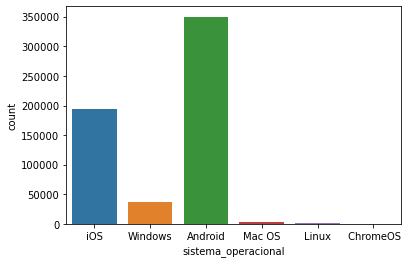

In [97]:
# vendo a contagem do sist. operacional
sns.countplot(x="sistema_operacional", data=base_final);

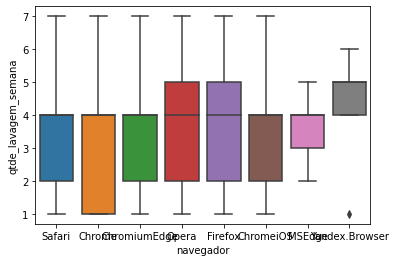

In [98]:
# vendo a contagem do navegador
sns.boxplot(x="navegador", y="qtde_lavagem_semana", data=base_final);

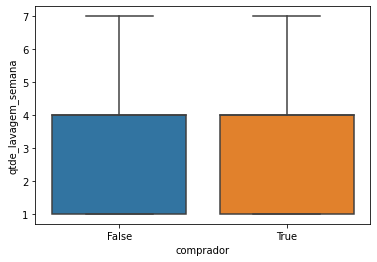

In [99]:
# vendo a distribuicao de qt de lavagem por semana
sns.boxplot(x="comprador", y="qtde_lavagem_semana", data=base_final);

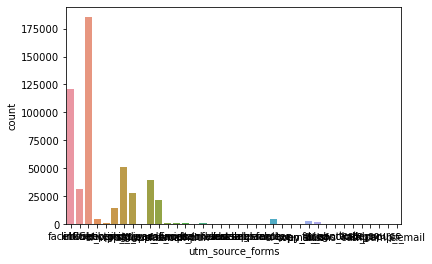

In [100]:
# vendo a distribuicao de utm_source_forms
sns.countplot(x="utm_source_forms", data=base_final);

In [101]:
# vendo a contagem de utm
base_final['utm_source_forms'].value_counts()

influencer         185530
facebook           120893
google              50676
sf_wpp_camp         38983
linktree            31610
instagram           27392
sf_email_camp       21435
sf_wpp_flux         14679
rakuten              4733
IGShopping           4613
email_sf             2321
blog                 1764
tiktok               1132
microinfluencer      1014
adwords               924
site                  802
sf_email_flux         530
meliuz                 98
incicacao              76
salesforce             67
whatsapp               29
sendinblue             19
telegram               19
sf_sms_camp            10
cpc                     7
sf_wpp_flu              7
sms                     4
teste_source            4
facebook                3
uaubox                  2
popup                   2
sf_camp_email           2
email                   1
copy_link               1
Facebook ads            1
santander               1
all                     1
sf_                     1
Name: utm_so

In [102]:
base_final.columns

Index(['id_form', 'id_cliente_forms', 'data', 'sistema_operacional',
       'navegador', 'localizacao', 'locale_forms', 'cidade_forms',
       'estado_forms', 'qtde_lavagem_semana', 'utm_source_forms',
       'tipo_cabelo', 'comprimento', 'tipo_fios', 'procedimentos',
       'tempo_procedimento', 'dieta', 'atividade_fisica',
       'frequencia_estresse', 'caracteristica', 'faixa_etaria',
       'efeitos_desejados', 'fragancia', 'id_pedido', 'id_cliente_order',
       'data_pedido', 'status_pagamento', 'tipo_pagamento', 'valor_total',
       'valor_desconto', 'frete_gratis', 'cidade_order', 'estado_order',
       'locale_order', 'utm_source_order', 'target', 'id', 'id_produto',
       'qtde', 'valor', 'comprador'],
      dtype='object')

### 5) Preparação da base

In [103]:
# mudando a coluna comprador para 0 e 1
base_final['comprador'] = base_final['comprador'].map({True: 1, False: 0}).astype("category")

In [104]:
# criando a categoria de outros (-1000 de frequencia)
base_final.loc[base_final['procedimentos'].isin((base_final['procedimentos'].value_counts()[base_final['procedimentos'].value_counts() < 1000]).index), 'procedimentos'] = 'others'
base_final.loc[base_final['utm_source_forms'].isin((base_final['utm_source_forms'].value_counts()[base_final['utm_source_forms'].value_counts() < 1000]).index), 'utm_source_forms'] = 'others'
base_final.loc[base_final['caracteristica'].isin((base_final['caracteristica'].value_counts()[base_final['caracteristica'].value_counts() < 1000]).index), 'caracteristica'] = 'others'

In [105]:
# alterando com a freq < 1350 (melhor valor que concilia n freq com qtidade)
base_final.loc[base_final['efeitos_desejados'].isin((base_final['efeitos_desejados'].value_counts()[base_final['efeitos_desejados'].value_counts() < 1350]).index), 'efeitos_desejados'] = 'others'

In [106]:
# alterando estados com pouca freq para 'others' (a variavel país está errada, poderia ser consertada)
base_final.loc[base_final['estado_forms'].isin((base_final['estado_forms'].value_counts()[base_final['estado_forms'].value_counts(normalize=True) < 0.001]).index), 'estado_forms'] = 'others'

In [107]:
# alterando sist operacional pouco usado para 'others' 
base_final.loc[base_final['sistema_operacional'].isin((base_final['sistema_operacional'].value_counts()[base_final['sistema_operacional'].value_counts() < 3500]).index), 'sistema_operacional'] = 'others'

In [108]:
# excluindo a coluna comprador e colocando a target
base_final['target'] = base_final['comprador']
del base_final['comprador']

In [109]:
# selecionando colunas para o modelo
dataset = base_final[['data', 'sistema_operacional',
       'navegador', 'estado_forms', 
                      'qtde_lavagem_semana', 'utm_source_forms',
       'tipo_cabelo', 'comprimento', 'tipo_fios', 'procedimentos',
       'tempo_procedimento', 'dieta', 'atividade_fisica',
       'frequencia_estresse', 'caracteristica', 'faixa_etaria',
       'efeitos_desejados', 'fragancia', 'target']]

In [110]:
# criando colunas de tempo
dataset['mes'] = dataset['data'].dt.month
dataset['dia'] = dataset['data'].dt.day
dataset['weekday'] = dataset['data'].dt.weekday

In [111]:
# Pegando o turno
def f(x):
    if (x > 6) and (x <= 12 ):
        return 'Manhã'
    elif (x > 12) and (x <= 18):
        return'Tarde'
    elif (x > 18) and (x <= 24) :
        return 'Noite'
    elif (x > 0) and (x <= 6):
        return'Madrugada'
    
dataset['turno'] = dataset['data'].dt.hour.apply(f)

del dataset['data']

In [112]:
# criando uma variavel de regiao
regiao = {
    "Norte":[' AMAZONAS', ' PARA', ' RORAIMA', ' ACRE',' RONDONIA',' AMAPA', ' TOCANTINS'],
    "Sul":[' PARANA', ' SANTA CATARINA', ' RIO GRANDE DO SUL'],
    "Centro Oeste":[' MATO GROSSO', ' MATO GROSSO DO SUL', ' GOIAS', ' FEDERAL DISTRICT'],
    "Nordeste":[' BAHIA', ' CEARA',' MARANHAO', ' PARAÍBA', ' PERNAMBUCO', ' RIO GRANDE DO NORTE',
                ' SERGIPE', ' ALAGOAS', ' PIAUI'],
    "Sudeste":[' SAO PAULO', ' RIO DE JANEIRO', ' MINAS GERAIS',' ESPIRITO SANTO'],
}
 
for k in regiao:
    dataset.loc[ dataset['estado_forms'].isin(regiao[k]), 'regiao'] = k
    
del dataset['estado_forms']

In [113]:
# Função para calcular valores faltantes
def missing_values_table(df):
        # Total de valores faltantes
        mis_val = df.isnull().sum()
        
        # Percentagem de valores faltantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Fazendo uma tabela com os resultados
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
        
        # Renomeando as colunas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores Missing', 1 : '% of Valores Totais'})
        
        # Ordenado a tabela pela percentagem de valores faltantes
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Valores Totais', ascending=False).round(1)
        
        # Print summary information
        print ("Este dataframe tem " + str(df.shape[1]) + " colunas.\n"      
            "Existem " + str(mis_val_table_ren_columns.shape[0]) +
              " colunas que tem valores faltantes.")
        
        # Returnar o dataframe com a informação dos valores missing
        return mis_val_table_ren_columns

In [114]:
# Calculando a % de valores faltantes
missing_values_table(dataset)

Este dataframe tem 22 colunas.
Existem 5 colunas que tem valores faltantes.


,Valores Missing,% of Valores Totais
navegador,131979,22.5
utm_source_forms,76086,13.0
regiao,18208,3.1
turno,16654,2.8
efeitos_desejados,1241,0.2


In [115]:
# Separando o array em componentes de input e output
X = dataset.loc[:, dataset.columns !='target']
y = dataset['target'].values

In [116]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(380556, 21) (204916, 21) (380556,) (204916,)


In [117]:
# Transformando os dados para a mesma escala (entre 0 e 1)

# Mudando somente as colunas numéricas
colunas = ['qtde_lavagem_semana', 'mes','dia','weekday']

# Dados de treino
df = X_train[colunas]
X = df.values

# Dados de teste
df2 = X_test[colunas]
X_2 = df2.values

# Gerando a nova escala para os dados de treino e teste
scaler = MinMaxScaler(feature_range = (0, 1)).fit(X)

rescaledX = scaler.transform(X)
rescaledX_test = scaler.transform(X_2)

# Adicionando os dados normalizados para o dataset original

# Dados de treino
X_train[colunas] = rescaledX

# Dados de teste
X_test[colunas] = rescaledX_test

In [118]:
# criando o hot encoding e alinhando as variaveis categorias no treino e teste
train = pd.get_dummies(X_train)   # gives (380556, 255)  
test = pd.get_dummies(X_test)    # gives (204916, 255)  
final_train, final_test = train.align(test, join='inner', axis=1)  # inner join

In [119]:
# Importância do Atributo com o Extra Trees Classifier

# Separando o array em componentes de input e output
X = final_train.values

# Criação do Modelo - Feature Selection
modelo = ExtraTreesClassifier(n_estimators = 50)
modelo.fit(X, y_train)

# Print dos Resultados
print(final_train.columns)
print(modelo.feature_importances_)

Index(['qtde_lavagem_semana', 'mes', 'dia', 'weekday',
       'sistema_operacional_Android', 'sistema_operacional_Windows',
       'sistema_operacional_iOS', 'sistema_operacional_others',
       'navegador_Chrome', 'navegador_ChromeiOS',
       ...
       'fragancia_Rosas', 'turno_Madrugada', 'turno_Manhã', 'turno_Noite',
       'turno_Tarde', 'regiao_Centro Oeste', 'regiao_Nordeste', 'regiao_Norte',
       'regiao_Sudeste', 'regiao_Sul'],
      dtype='object', length=228)
[3.02044992e-02 3.21787675e-02 3.54035944e-02 3.19708524e-02
 5.98091122e-03 2.65665692e-03 3.67457753e-03 1.24964155e-03
 4.09723394e-03 1.02832940e-03 5.81163366e-04 4.48071888e-04
 2.40650908e-06 2.62132816e-04 4.27131533e-03 5.61858698e-07
 1.78025394e-03 6.99265381e-04 8.96561573e-04 1.38344529e-02
 6.96607772e-03 1.12117511e-02 4.41540749e-03 5.01907221e-03
 3.53245316e-04 9.99183269e-04 1.74348447e-03 4.47893388e-03
 6.54571671e-03 4.30652517e-03 3.45713812e-04 1.51516810e-02
 1.45388762e-02 4.14287335e-03 9.1

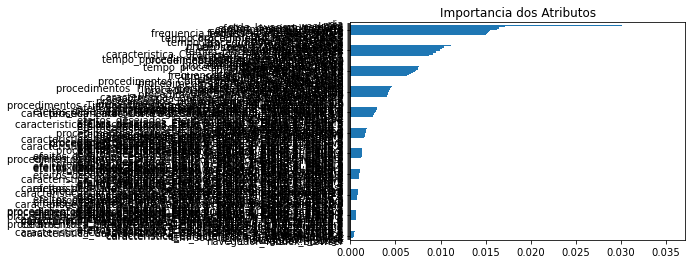

In [120]:
# Plotando as variaveis mais importantes
feat_importances = pd.Series(modelo.feature_importances_, index = final_train.columns)
feat_importances.sort_values(ascending = True).plot(kind = 'barh')
plt.title('Importancia dos Atributos')
plt.show()

In [121]:
# filtrando as colunas que tem importancia > 0.005
colunas_filtrar = pd.DataFrame(feat_importances[feat_importances.sort_values(ascending = False)>0.0025])
colunas_filtrar = np.array(colunas_filtrar.index)

In [122]:
len(colunas_filtrar)

98

In [123]:
# pegando os valores
X_treino = final_train[colunas_filtrar].values
X_teste = final_test[colunas_filtrar].values

### 6) Ajuste do modelo

In [124]:
# Acurácia
# Definindo os valores para o número de folds
num_folds = 10
num_instances = len(X)
seed = 7

# Separando os dados em folds
kfold = model_selection.KFold(num_folds, shuffle = True, random_state = seed)

# Criando o modelo
modelo = LogisticRegression()
modelo.fit(X_treino,y_train)
           
resultado = model_selection.cross_val_score(modelo, X_treino, y_train, cv = kfold, scoring = 'accuracy')

# Print dos resultados
print("Acurácia: %.3f (%.3f)" % (resultado.mean(), resultado.std()))

Acurácia: 0.657 (0.003)


### 7) Previsão

In [125]:
# Aplicando o modelo aos dados de teste
previsoes = modelo.predict(X_teste)

# A acurácia ficou em 0.66, muito próximo do que conseguimos nos dados de treino
print(accuracy_score(y_test, previsoes))
print(confusion_matrix(y_test, previsoes))
print(classification_report(y_test, previsoes))

# Printando as probabilidades das opções
print(modelo.predict_proba(X_teste))

0.6553709812801343
[[116737  14060]
 [ 56560  17559]]
              precision    recall  f1-score   support

           0       0.67      0.89      0.77    130797
           1       0.56      0.24      0.33     74119

    accuracy                           0.66    204916
   macro avg       0.61      0.56      0.55    204916
weighted avg       0.63      0.66      0.61    204916

[[0.79216326 0.20783674]
 [0.56986446 0.43013554]
 [0.41786619 0.58213381]
 ...
 [0.46746341 0.53253659]
 [0.56781118 0.43218882]
 [0.59724335 0.40275665]]


### 8) Interpretação

In [126]:
# salvando os coeficientes
w0 = modelo.intercept_[0]
w = modelo.coef_[0]

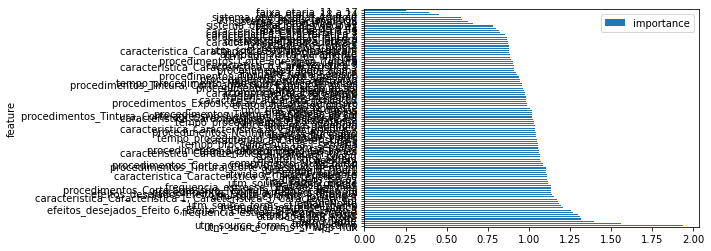

In [127]:
# criando um grafico de importancia das variaveis atraves dos coeficientes
feature_importance = pd.DataFrame(colunas_filtrar, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
 
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

In [128]:
feature_importance.head(10)

,feature,importance
16,utm_source_forms_sf_wpp_flux,1.939406
15,utm_source_forms_sf_wpp_camp,1.560091
90,turno_Manhã,1.396085
92,turno_Tarde,1.316927
91,turno_Noite,1.311886
56,atividade_fisica_N/C,1.298261
93,regiao_Centro Oeste,1.265754
60,frequencia_estresse_Regularmente,1.254355
84,"efeitos_desejados_Efeito 6, Efeito 7, Efeito 8...",1.208171
59,frequencia_estresse_Nunca,1.195631


É possível ver, através da tabela e do gráfico, que as variáveis de turno e utm_source_forms são bem importantes para o modelo e também aparece a frequencia de estresse como uma das mais importantes. Região Centro-oeste aparece também como um efeito significativo para afirmar se a pessoa virará um comprador ou não.

### 9) Conclusão

Mesmo com a criação de novas variáveis, feature selection e cross validation, ainda obtivemos um resultado não tão bom para a acurácia do modelo e outras métricas utilizadas. Nesse caso, seria necessário mais tempo para uma análise mais profunda dos dados e tentativa de ajuste de outros modelos.